In [1]:
# Import requisite modules
import math
import operator
import logging
import traceback
import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Qiskit packages
import qiskit 
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
# setup aqua logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
# set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

# The data providers of stock-market data
from qiskit.finance.data_providers import *
from qiskit.finance.applications.ising import portfolio_diversification

In [2]:
# Generate a pairwise time-series similarity matrix
n = 3
stocks = [("TICKER%s" % i) for i in range(n)]
## if loading fails, a constant matrix instead
# rho = np.ones((n,n))
# rho[0,1] = 0.8
# rho[1,0] = 0.8

data = RandomDataProvider(tickers = stocks,
                 start = datetime.datetime(2016,1,1),
                 end = datetime.datetime(2016,1,30))
data.run()
rho = data.get_similarity_matrix() # using dynamic time warping

# Actually, we consider the additive inverse to invert the direction of optimisation.  
rho = -1 * rho

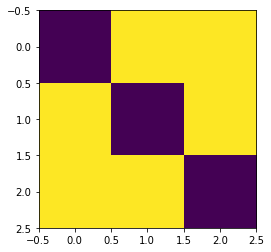

[[-1.00000000e+00 -6.84015983e-04 -1.47540606e-03]
 [-6.84015983e-04 -1.00000000e+00 -1.27522615e-03]
 [-1.47540606e-03 -1.27522615e-03 -1.00000000e+00]]


In [3]:
plt.imshow(rho)
plt.show()
print(rho)

The underlying evolution of stock prices:


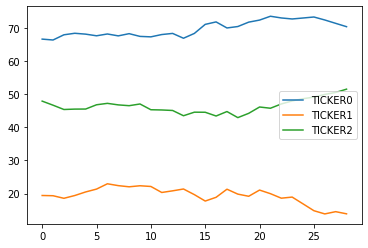

In [4]:
print("The underlying evolution of stock prices:")
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.show()

In [5]:
q = 1  # q less or equal than n

In [6]:
class ClassicalOptimizer:
    def __init__(self, rho, n, q):

        self.rho = rho
        self.n = n  # number of inner variables
        self.q = q  # number of required selection

    def compute_allowed_combinations(self):
        f = math.factorial
        return int(f(self.n) / f(self.q) / f(self.n - self.q))

    def cplex_solution(self):

        # refactoring
        rho = self.rho
        n = self.n
        q = self.q

        my_obj = list(rho.reshape(1, n ** 2)[0]) + [0. for x in range(0, n)]
        my_ub = [1 for x in range(0, n ** 2 + n)]
        my_lb = [0 for x in range(0, n ** 2 + n)]
        my_ctype = "".join(['I' for x in range(0, n ** 2 + n)])

        my_rhs = [q] + [1 for x in range (0, n)] +[0 for x in range (0, n)] + [0.1 for x in range(0, n ** 2)]
        my_sense = "".join(['E' for x in range(0, 1+n)]) + "".join(['E' for x in range(0, n)]) + "".join(
            ['L' for x in range(0, n ** 2)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        col = [x for x in range(n**2, n**2+n)]
        coef = [1 for x in range(0, n)]
        rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0+n*ii, n+n*ii)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        for ii in range(0, n):
            col = [ii * n + ii, n ** 2 + ii]
            coef = [1, -1]
            rows.append([col, coef])

        for ii in range(0, n):
            for jj in range(0, n):
                col = [ii*n + jj, n ** 2 + jj]
                coef = [1, -1]

                rows.append([col, coef])
        
        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [7]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(rho, n, q)

# Compute the number of feasible solutions:
print('Number of feasible combinations= ' + str(classical_optimizer.compute_allowed_combinations()))

# Compute the total number of possible combinations (feasible + unfeasible)
print('Total number of combinations= ' + str(2 ** (n*(n+1))))

Number of feasible combinations= 3
Total number of combinations= 4096


In [8]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    # 各銘柄の座標
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.015, yc[i]), size=16, color='r')
    
    plt.grid()

    # y_j : which stocks j are in the index fund
    for ii in range(n ** 2, n **2 + n):

        if x[ii] > 0:
            # plot coordinate of the stocks in the index fund
            plt.plot(xc[ii-n**2], yc[ii-n**2], 'r*', ms=20)

    # x_ij
    for ii in range(0, n ** 2):

        if x[ii] > 0:
            iy = ii // n # i
            ix = ii % n # j
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], 'C2')

    plt.title(title_str +' cost = ' + str(int(C * 100) / 100.))
    plt.show()

In [9]:
from qiskit.aqua.operators import StateFn

class QuantumOptimizer:

    def __init__(self, rho, n, q):

        self.rho = rho
        self.n = n
        self.q = q

    # Obtains the least eigenvalue of the Hamiltonian classically
    def exact_solution(self):
        qubitOp = portfolio_diversification.get_operator(self.rho, self.n, self.q)
        result = NumPyMinimumEigensolver(qubitOp).run()
        return self.decode_result(result)

    def vqe_solution(self):
        qubitOp = portfolio_diversification.get_operator(self.rho, self.n, self.q)
        backend = Aer.get_backend('statevector_simulator')
        seed = 50
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='full')
        vqe = VQE(qubitOp, ry, cobyla)
        vqe.random_seed = seed
        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
        result = vqe.run(quantum_instance)
        return self.decode_result(result)
        
    def qaoa_solution(self):
        qubitOp = portfolio_diversification.get_operator(self.rho, self.n, self.q)
        backend = Aer.get_backend('statevector_simulator')
        seed = 50
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        qaoa = QAOA(qubitOp, cobyla, 3, 'matrix')
        qaoa.random_seed = seed
        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
        result = qaoa.run(quantum_instance)
        return self.decode_result(result)
    
    def get_portfoliodiversification_solution(self, n, result):
        v = result.eigenstate
        if isinstance(v, StateFn):
            v = v.to_matrix()
        
        N = n ** 2 + n

        index_value = [x for x in range(len(v)) if v[x] == max(v)][0]
        string_value = "{0:b}".format(index_value)

        while len(string_value) < N:
            string_value = '0' + string_value

        x_state = list()
        for elements in string_value:
            if elements == '0':
                x_state.append(0)
            else:
                x_state.append(1)

        x_state = np.flip(x_state, axis=0)

        return x_state

    def decode_result(self, result, offset = 0):
        quantum_solution = self.get_portfoliodiversification_solution(self.n, result)
        ground_level = portfolio_diversification.get_portfoliodiversification_value(self.rho, self.n, self.q, quantum_solution)
        return quantum_solution, ground_level

# Step1

In [10]:
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer = QuantumOptimizer(rho, n, q)

# Step2

In [11]:
# Check if the binary representation is correct. This requires CPLEX
try: 
    import cplex
    #warnings.filterwarnings('ignore')
    quantum_solution, quantum_cost = quantum_optimizer.exact_solution()
    classical_solution, classical_cost = classical_optimizer.cplex_solution()
    print(quantum_cost, classical_cost)
    if np.abs(quantum_cost - classical_cost) < 0.01:
        print('Binary formulation is correct')
    else: print('Error in the formulation of the Hamiltonian')
except Exception as ex:
    print(ex)

-1.0027506322167028 -1.002750632216948
Binary formulation is correct


# Step3

In [12]:
ground_state, ground_level = quantum_optimizer.exact_solution()
print(ground_state, ground_level)

try:
    if np.abs(ground_level - classical_cost)<0.01:
        print('Ising Hamiltonian in Z basis is correct')
    else: print('Error in the Ising Hamiltonian formulation')
except Exception as ex:
    print(ex)

[0 0 1 0 0 1 0 0 1 0 0 1] -1.0027506322167028
Ising Hamiltonian in Z basis is correct


# Step4

In [18]:
vqe_state, vqe_level = quantum_optimizer.vqe_solution()
print(vqe_state, vqe_level)

try:
    if np.linalg.norm(ground_state - vqe_state)<0.01:
        print('VQE produces the same solution as the exact eigensolver.')
    else: print('VQE does not produce the same solution as the exact eigensolver, but that is to be expected.')
except Exception as ex:
    print(ex)

[0 1 0 0 1 0 1 1 0 0 1 0] 1998.9965653518002
VQE does not produce the same solution as the exact eigensolver, but that is to be expected.


In [14]:
# qaoa_state, qaoa_level = quantum_optimizer.qaoa_solution()
# print(qaoa_state)

# try:
#     if np.linalg.norm(ground_state - qaoa_state)<0.01:
#         print('QAOA produces the same solution as the exact eigensolver.')
#     else: print('QAOA does not produce the same solution as the exact eigensolver, but that is to be expected.')
# except Exception as ex:
#     print(ex)

# Step5

In [15]:
xc, yc = data.get_coordinates() # generate random coordinate

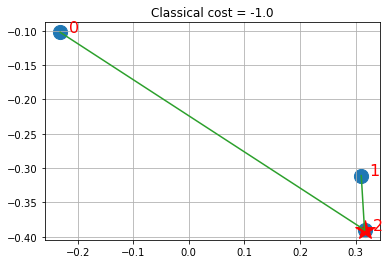

In [16]:
visualize_solution(xc, yc, ground_state, ground_level, n, q, 'Classical')

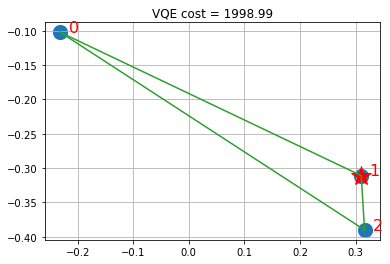

In [19]:
visualize_solution(xc, yc, vqe_state, vqe_level, n, q, 'VQE')